In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
#Loading the data
movies = pd.read_csv('archive (2)/oscars_df.csv').drop(columns = 'Unnamed: 0')
#Making IMDB Votes an integer
movies['IMDB Votes'] = movies['IMDB Votes'].apply(lambda x: int(x.replace(',','')))

In [4]:
# EDA Preprocessing to get numerical columns

d = {}
l = []
for col in movies.columns:
    if movies[col].dtype == 'object':
    else:
        if col != 'Year of Release':
            l.append(col)
            d[col] = ['mean', 'median']

In [14]:
# Making Oscar Year an Integer
movies['Oscar Year Int'] = movies['Oscar Year'].apply(lambda x: int(x[:2] + x[5:]) if '/' in x else int(x))

In [15]:
#Separating the winners from the nominees
winners = movies[movies['Award'] == 'Winner']
noms = movies[movies['Award'] == 'Nominee']

In [16]:
# General Stats of the dataframe
agged = movies.groupby('Award').agg(d)
agged

Movie Time        IMDB Rating            IMDB Votes            \
               mean median        mean median           mean    median   
Award                                                                    
Nominee  122.228033  119.0    7.528870    7.6  179554.050209   41744.5   
Winner   138.602151  130.0    7.783871    7.9  357155.473118  183677.0   

        Tomatometer Rating        Tomatometer Count        Audience Rating  \
                      mean median              mean median            mean   
Award                                                                        
Nominee          87.694678   91.0        109.770308   48.0       82.280112   
Winner           86.670732   91.5        114.731707   71.0       83.073171   

               Audience Count          Tomatometer Top Critics Count         \
        median           mean   median                          mean median   
Award                                                                         
Nominee   85.0   1.201210e+05  31834.0                     21.285714   10.0   
Winner    87.5   2.236387e+06  47682.0                     24.365854   16.0   

        Tomatometer Fresh Critics Count         \
                                   mean median   
Award                                            
Nominee                       97.509804   45.0   
Winner                       102.658537   62.5   

        Tomatometer Rotten Critics Count         
                                    mean median  
Award                                            
Nominee                        12.319328    4.0  
Winner                         12.085366    7.0

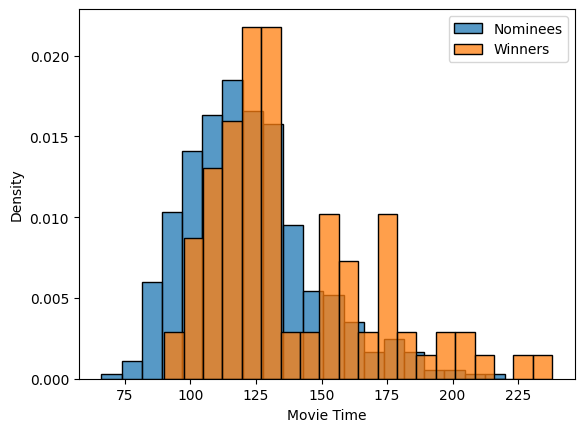

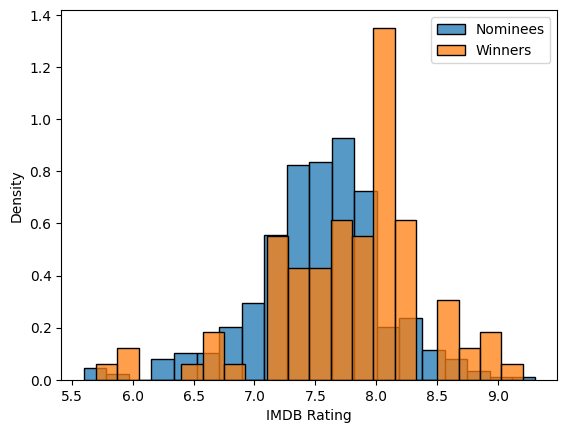

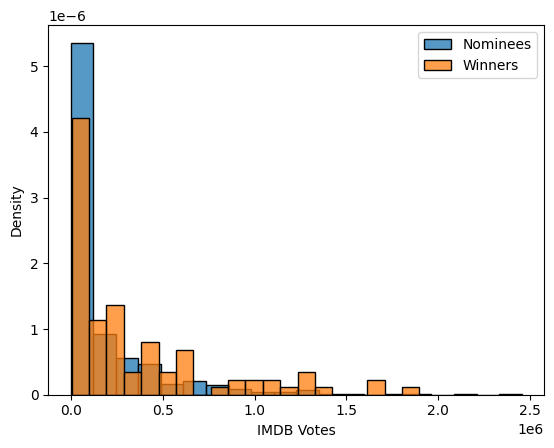

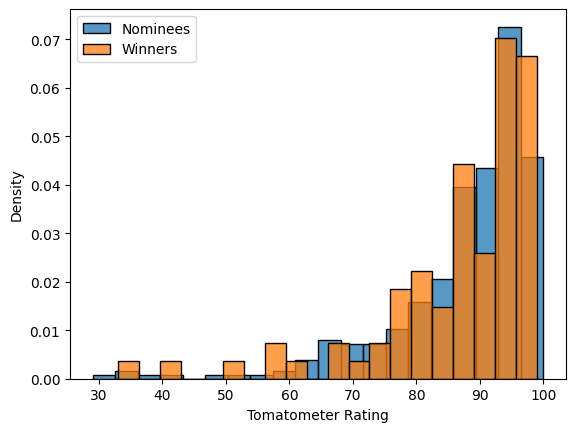

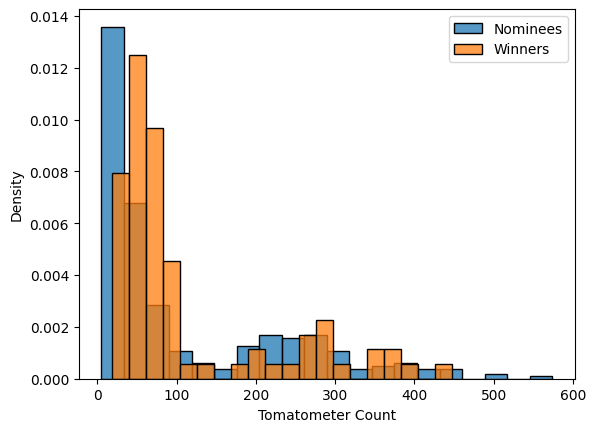

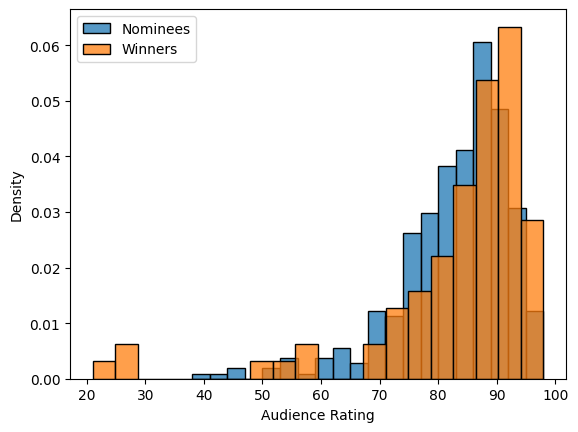

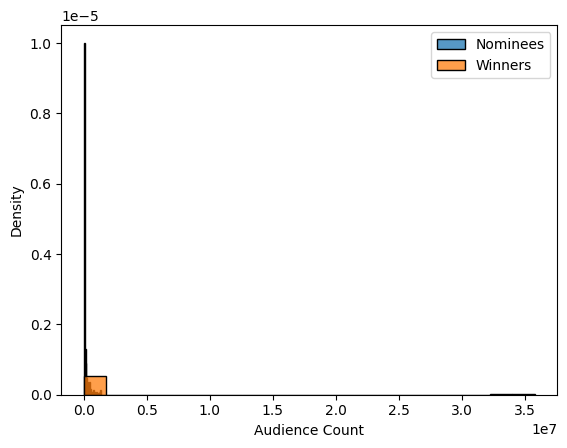

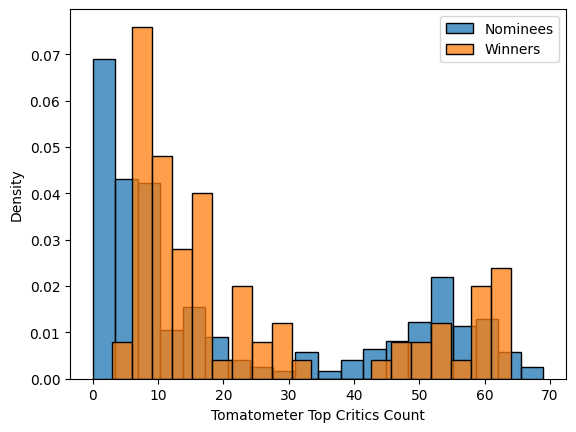

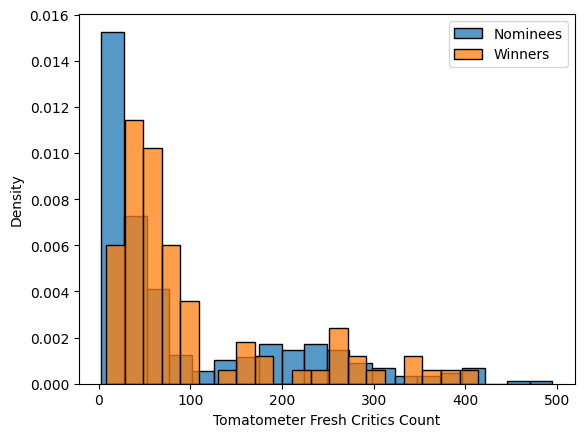

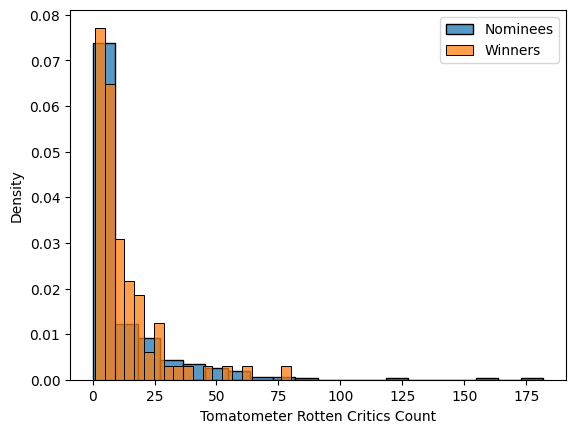

In [19]:
#Histograms of every quantitative feature with its sucesss at Best Picture
columns = l
for column in columns:
    sns.histplot(movies[movies['Award'] != 'Winner'][column],stat = 'density', bins = 20, label = 'Nominees')
    sns.histplot(movies[movies['Award'] == 'Winner'][column], stat = 'density', bins = 20, label = 'Winners')
    plt.legend()
    plt.show()

<Axes: xlabel='Oscar Year Int', ylabel='IMDB Votes'>

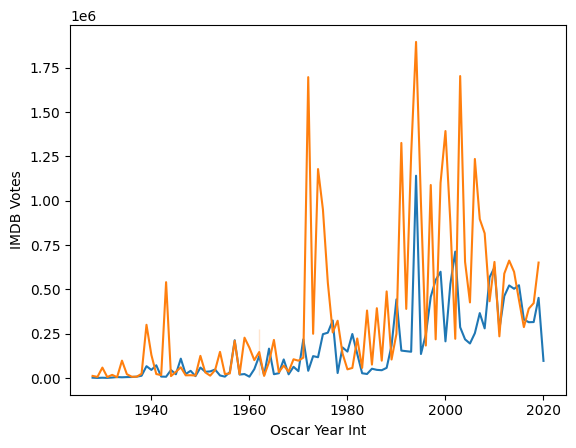

In [20]:
# Looking at the Winners stat compared to the average
stat = 'IMDB Votes'
data = movies[movies['Award'] != 'Winner'].groupby('Oscar Year Int')[stat].mean()
sns.lineplot(data = data)
sns.lineplot(data = movies[movies['Award'] == 'Winner'], x = 'Oscar Year Int', y = stat)

In [21]:
# Seeing why Audience Count is so off
movies[['Film', 'Audience Count']].sort_values('Audience Count', ascending = False)

,Film,Audience Count
405,Titanic,35797635.0
435,The Lord of the Rings: The Return of the King,34679773.0
420,Gladiator,34128168.0
300,Rocky,33403994.0
395,Braveheart,32708456.0
...,...,...
566,Mank,NaN
567,Minari,NaN
568,Promising Young Woman,NaN
569,Sound of Metal,NaN


In [44]:
# This code was used to see if there was any reason to why there are missing values
#for year in movies['Oscar Year Int'].unique():
    #for col in movies.columns:
        #if (movies[movies['Oscar Year Int'] == year][col].isna().mean()) > 0:
                
                #print(str(col) + ', ' + str(year) + ' : Nominees Nas: ' + str(noms[noms['Oscar Year Int'] == year][col].isna().mean()) +
                     # ' Winners Nas: ' + str(winners[winners['Oscar Year Int'] == year][col].isna().mean()) )

In [24]:
# This Movie has a Rotten Tomatoes, Therefore there is missing data. 
for col in movies.columns:
    print(str(col)  + ' : ' + str(movies.iloc[-2][col]))

Film : Sound of Metal
Oscar Year : 2020
Film Studio/Producer(s) : Bert Hamelinck and Sacha Ben Harroche
Award : Nominee
Year of Release : 2019
Movie Time : 120
Movie Genre : Drama,Music
IMDB Rating : 7.8
IMDB Votes : 102807
Movie Info : nan
Genres : nan
Critic Consensus : nan
Content Rating : nan
Directors : nan
Authors : nan
Actors : nan
Original Release Date : nan
Streaming Release Date : nan
Production Company : nan
Tomatometer Status : nan
Tomatometer Rating : nan
Tomatometer Count : nan
Audience Status : nan
Audience Rating : nan
Audience Count : nan
Tomatometer Top Critics Count : nan
Tomatometer Fresh Critics Count : nan
Tomatometer Rotten Critics Count : nan
Film ID : 647357e9-c067-46bd-aaeb-24d4344ec124
Oscar Year Int : 2020


In [25]:
# Only Looking at columns that: 
# 1. Have full and valid values
# 2. Are rating based

cleaned = movies[['Film','Oscar Year Int', 'Award', 'IMDB Rating', 'IMDB Votes']]

In [26]:
#Checking for missing values
for col in cleaned.columns:
    print(cleaned[col].isna().sum())

0
0
0
0
0


In [148]:
# First try at a model
# Result: The model predicts way to many movies to be winners - as only one can win each year

X_1, y_1 = cleaned[['IMDB Rating', 'IMDB Votes']], (cleaned['Award'] == 'Winner').astype(int)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, random_state = 42)

model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train_1, y_train_1)
train_pred1 = model1.predict(X_train_1)
test_pred1 = model1.predict(X_test_1)

print(classification_report(y_train_1, train_pred1))
print(confusion_matrix(y_train_1, train_pred1))
print(classification_report(y_test_1, test_pred1))
print(confusion_matrix(y_test_1, test_pred1))


              precision    recall  f1-score   support

           0       0.88      0.78      0.82       360
           1       0.26      0.41      0.32        68

    accuracy                           0.72       428
   macro avg       0.57      0.59      0.57       428
weighted avg       0.78      0.72      0.74       428

[[280  80]
 [ 40  28]]
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       118
           1       0.22      0.28      0.25        25

    accuracy                           0.70       143
   macro avg       0.53      0.53      0.53       143
weighted avg       0.73      0.70      0.71       143

[[93 25]
 [18  7]]


In [377]:
#Sampling based on years
yrs = cleaned['Oscar Year Int'].unique()
sample_years = np.random.choice(yrs, size = int(len(yrs)  * 0.2), replace = False)

In [370]:
#Initializing a results dictionary that will get updated with accuracies
results = {}

In [381]:


#Takes predictions and returns the films that have the highest 'score' in each year
def process_predictions(predictions, years, year_col = 'Oscar Year Int'):
    winners = []
    df = pd.concat([years.reset_index(drop = True), pd.DataFrame(predictions)], axis = 1)
    yrs = years[year_col].unique()
    for yr in yrs:
        t = df[df[year_col] == yr]
        winners.append(df.iloc[t[0].idxmax()]['Film'])
    return winners

#Takes an output of the above function and compares to the actual results, computing an accuracy score of correctly
# predicted years over total years
def compute_accuracy(predictions, actual, to_print = True):
    size = len(predictions)
    acc = 0
    for i in range(size):
        acc = acc + int(predictions[i] == actual[i])
    if to_print:
        print(f"{acc} / {size}")
    return acc / size

#Split into test and train 
test_bucketed = cleaned[cleaned['Oscar Year Int'].apply(lambda x : x in sample_years)]
train_bucketed = cleaned[cleaned['Oscar Year Int'].apply(lambda x: x not in sample_years)]

# Split into x and y
X_train, y_train = train_bucketed[['IMDB Rating', 'IMDB Votes']], (train_bucketed['Award'] == 'Winner').astype(int)
X_test, y_test = test_bucketed[['IMDB Rating', 'IMDB Votes']], (test_bucketed['Award'] == 'Winner').astype(int)

#Model 1
dt = DecisionTreeRegressor(max_depth = 5)
dt.fit(X_train,y_train)
predic = dt.predict(X_train)
preds =  process_predictions(predic, train_bucketed)
print(compute_accuracy(preds, train_bucketed[train_bucketed['Award'] == 'Winner']['Film'].reset_index(drop = True)))
test_predic = dt.predict(X_test)
test_preds = process_predictions(test_predic, test_bucketed)
print(compute_accuracy(test_preds, test_bucketed[test_bucketed['Award'] == 'Winner']['Film'].reset_index(drop = True)))
results['IMDB Simple'] = [compute_accuracy(preds, train_bucketed[train_bucketed['Award'] == 'Winner']['Film'].reset_index(drop = True)), 
                         compute_accuracy(test_preds, test_bucketed[test_bucketed['Award'] == 'Winner']['Film'].reset_index(drop = True))]

28 / 75
0.37333333333333335
7 / 18
0.3888888888888889
28 / 75
7 / 18


In [488]:
# Calculating Competition - looking at the average of all opponent's statistic in a given year
def calculate_opponent_feature(df, year_col, stat_col):
    opps = []
    years = df[year_col].unique()
    for year in years:
        year_slice = df[df[year_col] == year]
        ixs = year_slice.index
        #for i in ixs:
        for index_slice in [[x for x in ixs if i != x] for i in ixs]:
            opps.append(df.iloc[index_slice][stat_col].mean())
    return pd.DataFrame({"Average Opponent's " + str(stat_col):opps})

In [40]:
#Example Output of IMDB Rating competition 
calculate_opponent_feature(cleaned, 'Oscar Year Int', 'IMDB Rating')

,Average Opponent's IMDB Rating
0,7.200000
1,7.100000
2,7.600000
3,6.125000
4,6.100000
...,...
566,7.685714
567,7.600000
568,7.600000
569,7.557143


In [43]:
# Creating features for Model 2
cleaned_opp = pd.concat([cleaned, calculate_opponent_feature(cleaned, 'Oscar Year Int', 'IMDB Rating')], axis = 1)
cleaned_opp = pd.concat([cleaned_opp, calculate_opponent_feature(cleaned, 'Oscar Year Int', 'IMDB Votes')], axis = 1)
cleaned_opp

,Film,Oscar Year Int,Award,IMDB Rating,IMDB Votes,Average Opponent's IMDB Rating,Average Opponent's IMDB Votes
0,Wings,1928,Winner,7.5,12221,7.200000,2348.000000
1,7th Heaven,1928,Nominee,7.7,3439,7.100000,6739.000000
2,The Racket,1928,Nominee,6.7,1257,7.600000,7830.000000
3,The Broadway Melody,1929,Winner,5.7,6890,6.125000,951.500000
4,Alibi,1929,Nominee,5.8,765,6.100000,2482.750000
...,...,...,...,...,...,...,...
566,Mank,2020,Nominee,6.9,65380,7.685714,101580.714286
567,Minari,2020,Nominee,7.5,57976,7.600000,102638.428571
568,Promising Young Woman,2020,Nominee,7.5,122269,7.600000,93453.714286
569,Sound of Metal,2020,Nominee,7.8,102807,7.557143,96234.000000


In [382]:

# Model 2
test_bucketed = cleaned_opp[cleaned_opp['Oscar Year Int'].apply(lambda x : x in sample_years)]
train_bucketed = cleaned_opp[cleaned_opp['Oscar Year Int'].apply(lambda x: x not in sample_years)]


X_train, y_train = train_bucketed[['IMDB Rating', 'IMDB Votes', "Average Opponent's IMDB Rating", "Average Opponent's IMDB Votes"]], (train_bucketed['Award'] == 'Winner').astype(int)
X_test, y_test = test_bucketed[['IMDB Rating', 'IMDB Votes', "Average Opponent's IMDB Rating", "Average Opponent's IMDB Votes"]], (test_bucketed['Award'] == 'Winner').astype(int)

dt = DecisionTreeRegressor(max_depth =5)
dt.fit(X_train,y_train)
predic = dt.predict(X_train)
preds =  process_predictions(predic, train_bucketed)
print(compute_accuracy(preds, train_bucketed[train_bucketed['Award'] == 'Winner']['Film'].reset_index(drop = True)))
test_predic = dt.predict(X_test)
test_preds = process_predictions(test_predic, test_bucketed)
print(compute_accuracy(test_preds, test_bucketed[test_bucketed['Award'] == 'Winner']['Film'].reset_index(drop = True)))
results['IMDB Complex'] = [compute_accuracy(preds, train_bucketed[train_bucketed['Award'] == 'Winner']['Film'].reset_index(drop = True)), 
                         compute_accuracy(test_preds, test_bucketed[test_bucketed['Award'] == 'Winner']['Film'].reset_index(drop = True))]

26 / 75
0.3466666666666667
10 / 18
0.5555555555555556
26 / 75
10 / 18


In [166]:
#New Dataset
mov_feat = pd.read_csv('archive (2)/oscardata_bestpicture.csv')
mov_feat.head()

,Category,Film,Nominee,Winner,Year,Rating_IMDB,Release_date,Rating_rtaudience,Rating_rtcritic,Oscarstat_totalnoms,...,Nonom_Criticschoice,Nom_Criticschoice,Nowin_SAG_bestcast,Win_SAG_bestcast,Nonom_SAG_bestcast,Nom_SAG_bestcast,Nowin_PGA,Win_PGA,Nonom_PGA,Nom_PGA
0,Picture,The Apartment,The Apartment,1,1961,8.3,1960-09-16,94,93,10,...,0,0,0,0,0,0,0,0,0,0
1,Picture,The Alamo,The Alamo,0,1961,6.9,1960-10-24,64,50,6,...,0,0,0,0,0,0,0,0,0,0
2,Picture,Elmer Gantry,Elmer Gantry,0,1961,7.9,1960-07,86,96,5,...,0,0,0,0,0,0,0,0,0,0
3,Picture,Sons and Lovers,Sons and Lovers,0,1961,7.3,1960-07-22,54,75,7,...,0,0,0,0,0,0,0,0,0,0
4,Picture,The Sundowners,The Sundowners,0,1961,7.2,1961-02-28,62,78,5,...,0,0,0,0,0,0,0,0,0,0


In [167]:
#New Dataset columns
mov_feat.columns

Index(['Category', 'Film', 'Nominee', 'Winner', 'Year', 'Rating_IMDB',
       'Release_date', 'Rating_rtaudience', 'Rating_rtcritic',
       'Oscarstat_totalnoms', 'Release_Q1', 'Release_Q2', 'Release_Q3',
       'Release_Q4', 'Nom_Oscar_bestdirector', 'Nom_DGA', 'Nom_BAFTA',
       'Win_DGA', 'Win_BAFTA', 'Nom_GoldenGlobe_bestcomedy',
       'Nom_GoldenGlobe_bestdrama', 'Win_GoldenGlobe_bestcomedy',
       'Win_GoldenGlobe_bestdrama', 'Genre_action', 'Genre_biography',
       'Genre_crime', 'Genre_comedy', 'Genre_drama', 'Genre_horror',
       'Genre_fantasy', 'Genre_sci-fi', 'Genre_mystery', 'Genre_music',
       'Genre_romance', 'Genre_history', 'Genre_war', 'Genre_filmnoir',
       'Genre_thriller', 'Genre_adventure', 'Genre_family', 'Genre_sport',
       'Genre_western', 'MPAA_rating', 'MPAA_G', 'MPAA_PG', 'MPAA_PG-13',
       'MPAA_R', 'MPAA_NC-17', 'Nowin_Criticschoice', 'Win_Criticschoice',
       'Nonom_Criticschoice', 'Nom_Criticschoice', 'Nowin_SAG_bestcast',
       'Win_SAG

In [168]:
#Only selecting relevant features
mov_feat = mov_feat[mov_feat.columns[:10]]

In [169]:
#Seeing the difference between film and nominee column - there are little and they don't make a difference
for i in range(380):
    if mov_feat['Film'].iloc[i] != mov_feat['Nominee'].iloc[i]:
        print(mov_feat['Film'].iloc[i], mov_feat['Nominee'].iloc[i])

Secrets and Lies Secrets & Lies
Crouching Tiger, Hidden Dragon (Wo hu cang long) Crouching Tiger, Hidden Dragon
Extremely Loud and Incredibly Close Extremely Loud & Incredibly Close


In [170]:
# Only selecting relevant columns
mov_feat = mov_feat.drop(columns = ['Category', 'Nominee', 'Release_date'])

In [490]:
# Correlation Matrix 
mov_full[['Rating_IMDB', 'Rating_rtcritic', 'Rating_rtaudience', 'Oscarstat_totalnoms']].corr()

,Rating_IMDB,Rating_rtcritic,Rating_rtaudience,Oscarstat_totalnoms
Rating_IMDB,1.000000,0.349038,0.717632,0.161437
Rating_rtcritic,0.349038,1.000000,0.367754,-0.082430
Rating_rtaudience,0.717632,0.367754,1.000000,0.048464
Oscarstat_totalnoms,0.161437,-0.082430,0.048464,1.000000


In [209]:
# Sorting Alphabetically so as ties in the algorithm go to the first alphabetically
mov_feat = mov_feat.sort_values(['Year', 'Film']).reset_index(drop = True)


In [246]:
 # Unclear why there is an error here. 
mov_feat[mov_feat['Year'] == 2018]


,Film,Winner,Year,Rating_IMDB,Rating_rtaudience,Rating_rtcritic,Oscarstat_totalnoms
316,Call Me by Your Name,0,2018,8.3,87,96,3
317,Darkest Hour,0,2018,7.4,84,86,6
318,Dunkirk,0,2018,8.1,81,92,8
319,Get Out,0,2018,7.7,87,99,4
320,Lady Bird,0,2018,7.8,81,99,5
321,Phantom Thread,0,2018,8.3,61,91,6
322,The Post,0,2018,7.4,73,88,2
323,The Shape of Water,0,2018,7.8,92,78,13
324,"Three Billboards Outside Ebbing, Missouri",0,2018,8.3,87,93,7


In [249]:
# Fixing said error
mov_feat.loc[323, 'Winner'] = 1

In [383]:
#Randomly getting sample years again for the new dataset
yrs = mov_feat['Year'].unique()
sample_years = np.random.choice(yrs, size = int(len(yrs)  * 0.2), replace = False)

In [390]:

#Model 3
test_bucketed = mov_feat[mov_feat['Year'].apply(lambda x : x in sample_years)]
train_bucketed = mov_feat[mov_feat['Year'].apply(lambda x: x not in sample_years)]


X_train, y_train = train_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms']], (train_bucketed['Winner'])
X_test, y_test = test_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms']], (test_bucketed['Winner'])

dt = DecisionTreeRegressor(max_depth = 3)
dt.fit(X_train,y_train)
predic = dt.predict(X_train)
preds =  process_predictions(predic, train_bucketed, 'Year')
print(compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)))
test_predic = dt.predict(X_test)
test_preds = process_predictions(test_predic, test_bucketed, 'Year')
print(compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)))
results['Full Data Simple'] = [compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)), 
                         compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True))]

27 / 52
0.5192307692307693
5 / 12
0.4166666666666667
27 / 52
5 / 12


In [287]:
# Generating new Features
mov_full = pd.concat([mov_feat, calculate_opponent_feature(mov_feat, 'Year', 'Rating_IMDB')], axis = 1)
mov_full = pd.concat([mov_full, calculate_opponent_feature(mov_feat, 'Year', 'Rating_rtaudience')], axis = 1)
mov_full = pd.concat([mov_full, calculate_opponent_feature(mov_feat, 'Year', 'Rating_rtcritic')], axis = 1)
mov_full = pd.concat([mov_full, calculate_opponent_feature(mov_feat, 'Year', 'Oscarstat_totalnoms')], axis = 1)
mov_full

,Film,Winner,Year,Rating_IMDB,Rating_rtaudience,Rating_rtcritic,Oscarstat_totalnoms,Average Opponent's Rating_IMDB,Average Opponent's Rating_rtaudience,Average Opponent's Rating_rtcritic,Average Opponent's Oscarstat_totalnoms
0,Elmer Gantry,0,1961,7.9,86,96,5,7.425000,68.500000,74.000000,7.00
1,Sons and Lovers,0,1961,7.3,54,75,7,7.575000,76.500000,79.250000,6.50
2,The Alamo,0,1961,6.9,64,50,6,7.675000,74.000000,85.500000,6.75
3,The Apartment,1,1961,8.3,94,93,10,7.325000,66.500000,74.750000,5.75
4,The Sundowners,0,1961,7.2,62,78,5,7.600000,74.500000,78.500000,7.00
...,...,...,...,...,...,...,...,...,...,...,...
375,Oppenheimer,1,2024,8.3,91,93,1,7.422222,83.555556,91.777778,1.00
376,Past Lives,0,2024,7.8,93,95,1,7.477778,83.333333,91.555556,1.00
377,Poor Things,0,2024,7.8,80,93,1,7.477778,84.777778,91.777778,1.00
378,The Holdovers,0,2024,7.9,92,97,1,7.466667,83.444444,91.333333,1.00


In [397]:
# Model 4
test_bucketed = mov_full[mov_full['Year'].apply(lambda x : x in sample_years)]
train_bucketed = mov_full[mov_full['Year'].apply(lambda x: x not in sample_years)]


X_train, y_train = train_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms'
                                  ,"Average Opponent's Rating_IMDB", "Average Opponent's Rating_rtaudience", 
                                   "Average Opponent's Rating_rtcritic", "Average Opponent's Oscarstat_totalnoms" ]], (train_bucketed['Winner'])
X_test, y_test = test_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms'
                                  ,"Average Opponent's Rating_IMDB", "Average Opponent's Rating_rtaudience", 
                                   "Average Opponent's Rating_rtcritic", "Average Opponent's Oscarstat_totalnoms"]], (test_bucketed['Winner'])

dt = DecisionTreeRegressor(max_depth = 3)
dt.fit(X_train,y_train)
predic = dt.predict(X_train)
preds =  process_predictions(predic, train_bucketed, 'Year')
print(compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)))
test_predic = dt.predict(X_test)
test_preds = process_predictions(test_predic, test_bucketed, 'Year')
print(compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)))
results['Full Data Complex'] = [compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)), 
                         compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True))]

24 / 52
0.46153846153846156
5 / 12
0.4166666666666667
24 / 52
5 / 12


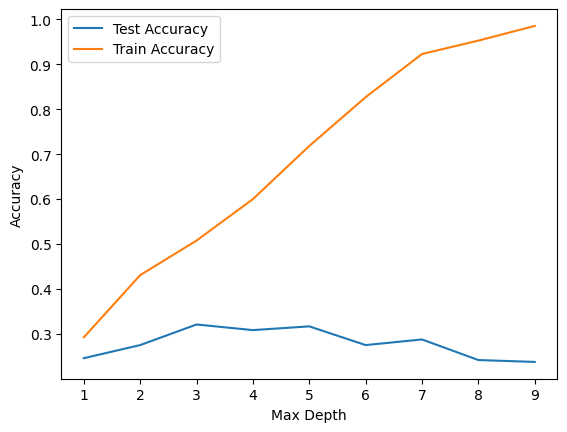

In [329]:
# Hyperparameter tuning of model 4 - note that there is no ideal parameter
test_acc, train_acc = [], []
for i in range(1,10):
    curr_train, curr_test = [], []
    for p in range(20):

        
        sample_years = np.random.choice(yrs, size = int(len(yrs)  * 0.2), replace = False)
        test_bucketed = mov_full[mov_full['Year'].apply(lambda x : x in sample_years)]
        train_bucketed = mov_full[mov_full['Year'].apply(lambda x: x not in sample_years)]
        X_train, y_train = train_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms'
                                  ,"Average Opponent's Rating_IMDB", "Average Opponent's Rating_rtaudience", 
                                   "Average Opponent's Rating_rtcritic", "Average Opponent's Oscarstat_totalnoms" ]], (train_bucketed['Winner'])
        X_test, y_test = test_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms'
                                  ,"Average Opponent's Rating_IMDB", "Average Opponent's Rating_rtaudience", 
                                   "Average Opponent's Rating_rtcritic", "Average Opponent's Oscarstat_totalnoms"]], (test_bucketed['Winner'])

        dt = DecisionTreeRegressor(max_depth = i)
        dt.fit(X_train,y_train)
        predic = dt.predict(X_train)
        preds =  process_predictions(predic, train_bucketed, 'Year')
        curr_train.append(compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True), to_print = False))
        test_predic = dt.predict(X_test)
        test_preds = process_predictions(test_predic, test_bucketed, 'Year')
        curr_test.append(compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True),to_print =  False))
    test_acc.append(np.mean(curr_test))
    train_acc.append(np.mean(curr_train))


plt.plot(range(1,10), test_acc)
plt.plot(range(1,10), train_acc)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend(["Test Accuracy", "Train Accuracy"])

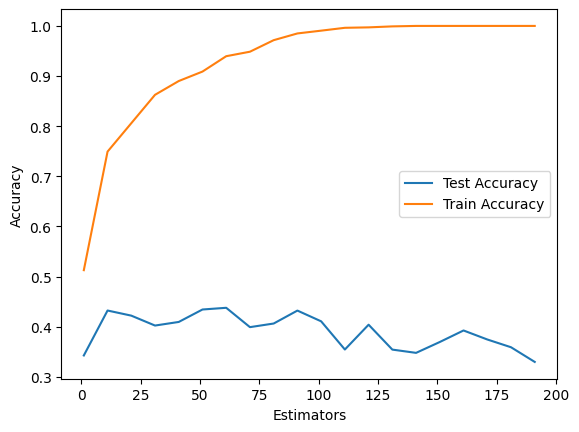

In [343]:
#Hyperparameter tuning of boosted model - note that there is no ideal parameter
test_acc, train_acc = [], []
for i in range(1,200, 10):
    curr_train, curr_test = [], []
    for p in range(20):

        
        sample_years = np.random.choice(yrs, size = int(len(yrs)  * 0.2), replace = False)
        test_bucketed = mov_full[mov_full['Year'].apply(lambda x : x in sample_years)]
        train_bucketed = mov_full[mov_full['Year'].apply(lambda x: x not in sample_years)]
        X_train, y_train = train_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms'
                                  ,"Average Opponent's Rating_IMDB", "Average Opponent's Rating_rtaudience", 
                                   "Average Opponent's Rating_rtcritic", "Average Opponent's Oscarstat_totalnoms" ]], (train_bucketed['Winner'])
        X_test, y_test = test_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms'
                                  ,"Average Opponent's Rating_IMDB", "Average Opponent's Rating_rtaudience", 
                                   "Average Opponent's Rating_rtcritic", "Average Opponent's Oscarstat_totalnoms"]], (test_bucketed['Winner'])

        dt = GradientBoostingRegressor(n_estimators = i)
        dt.fit(X_train,y_train)
        predic = dt.predict(X_train)
        preds =  process_predictions(predic, train_bucketed, 'Year')
        curr_train.append(compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True), to_print = False))
        test_predic = dt.predict(X_test)
        test_preds = process_predictions(test_predic, test_bucketed, 'Year')
        curr_test.append(compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True),to_print =  False))
    test_acc.append(np.mean(curr_test))
    train_acc.append(np.mean(curr_train))


plt.plot(range(1,200,10), test_acc)
plt.plot(range(1,200, 10), train_acc)
plt.xlabel("Estimators")
plt.ylabel("Accuracy")
plt.legend(["Test Accuracy", "Train Accuracy"])

In [398]:
# Boosted Model
test_bucketed = mov_full[mov_full['Year'].apply(lambda x : x in sample_years)]
train_bucketed = mov_full[mov_full['Year'].apply(lambda x: x not in sample_years)]


X_train, y_train = train_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms'
                                  ,"Average Opponent's Rating_IMDB", "Average Opponent's Rating_rtaudience", 
                                   "Average Opponent's Rating_rtcritic", "Average Opponent's Oscarstat_totalnoms" ]], (train_bucketed['Winner'])
X_test, y_test = test_bucketed[['Rating_IMDB', 'Rating_rtaudience', "Rating_rtcritic", 'Oscarstat_totalnoms'
                                  ,"Average Opponent's Rating_IMDB", "Average Opponent's Rating_rtaudience", 
                                   "Average Opponent's Rating_rtcritic", "Average Opponent's Oscarstat_totalnoms"]], (test_bucketed['Winner'])

dt = GradientBoostingRegressor(n_estimators = 15)
dt.fit(X_train,y_train)
predic = dt.predict(X_train)
preds =  process_predictions(predic, train_bucketed, 'Year')
print(compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)))
test_predic = dt.predict(X_test)
test_preds = process_predictions(test_predic, test_bucketed, 'Year')
print(compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)))
results['Boosted'] = [compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)), 
                         compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True))]

42 / 52
0.8076923076923077
7 / 12
0.5833333333333334
42 / 52
7 / 12


In [430]:
#Random Model
predic = np.random.rand(len(predic))
preds =  process_predictions(predic, train_bucketed, 'Year')
print(compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)))
test_predic = np.random.rand(len(test_predic))
test_preds = process_predictions(test_predic, test_bucketed, 'Year')
print(compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)))
results['Random'] = [compute_accuracy(preds, train_bucketed[(train_bucketed['Winner']) == 1]['Film'].reset_index(drop = True)), 
                         compute_accuracy(test_preds, test_bucketed[(test_bucketed['Winner']) == 1]['Film'].reset_index(drop = True))]

6 / 52
0.11538461538461539
1 / 12
0.08333333333333333
6 / 52
1 / 12


In [431]:
# Results df
result = pd.DataFrame(results).T.reset_index().rename(columns = {'index':'Model', 0:'Test Accuracy', 1:'Train Accuracy'})

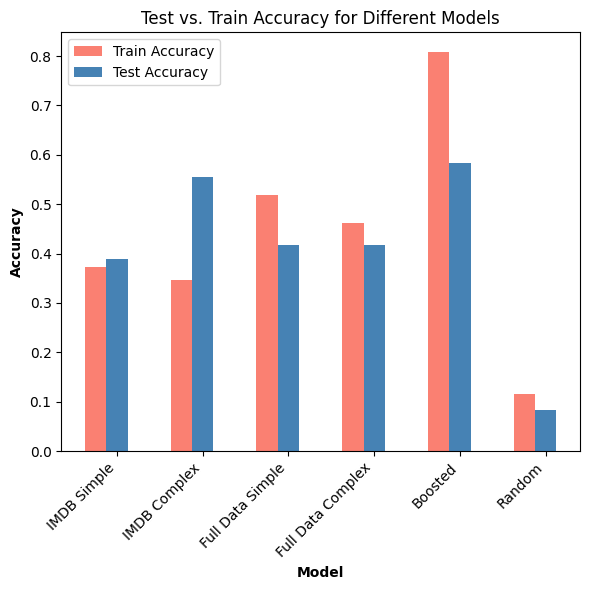

In [467]:
# Creating final bar graph of results

bar_width = 0.25

n = np.arange(len(result['Model']))
d = [x + bar_width for x in n]

plt.figure(figsize=(6, 6)) 

plt.bar(n, result['Test Accuracy'], color='salmon', width=bar_width, label='Train Accuracy')
plt.bar(d, result['Train Accuracy'], color='steelblue', width=bar_width, label='Test Accuracy')

plt.xlabel('Model', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Test vs. Train Accuracy for Different Models')
plt.xticks([r + bar_width for r in n], result['Model'], rotation=45, ha='right')
plt.legend()
plt.tight_layout() 
plt.show()